In [2]:
import hatchet as ht
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import re

In [3]:
datasets = glob.glob('perf_data/out_*.json')
datasets.sort()

In [4]:
dataframes = []
for dataset in datasets:
    gf = ht.GraphFrame.from_caliper_json(dataset)
    gf.drop_index_levels(np.max)
    n_sz = re.match('(.*)_(.*)_(\d+)(.*)', dataset).group(3)
    gf.dataframe['nsz'] = n_sz
    dataframes.append(gf.dataframe)


In [5]:
result = pd.concat(dataframes)

In [6]:
pivot_df = result.pivot(index='nsz', columns='name', values='time')

<AxesSubplot:xlabel='nsz'>

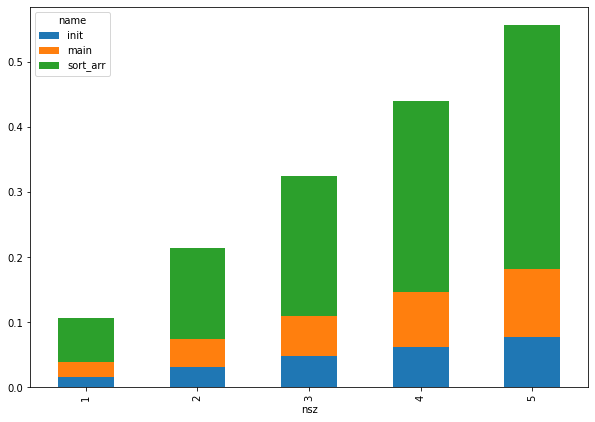

In [7]:
pivot_df.loc[:,:].plot.bar(stacked=True, figsize=(10,7))

In [8]:
from extrap.entities.experiment import Experiment
from extrap.entities.callpath import Callpath
from extrap.entities.metric import Metric
from extrap.entities.parameter import Parameter
from extrap.entities.coordinate import Coordinate
from extrap.entities.measurement import Measurement
from extrap.fileio import io_helper

from extrap.modelers.model_generator import ModelGenerator

In [9]:
pivot_df.head()

name,init,main,sort_arr
nsz,,,
1,0.015630,0.022853,0.068065
2,0.031240,0.043735,0.139912
3,0.047702,0.062297,0.215054
4,0.062506,0.083707,0.293924
5,0.077361,0.104749,0.374521


In [10]:
ex = Experiment()
cpath = Callpath('sort_arr')
ex.add_callpath(cpath)
ex.add_parameter(Parameter('nsz'))
met = Metric('time')
ex.add_metric(met)
ex.call_tree = io_helper.create_call_tree(ex.callpaths)

In [11]:
coordinates = [Coordinate(float(v)) for v in list(pivot_df.index)]
ex.coordinates.extend(coordinates)

In [12]:
for i in range(0, len(pivot_df.index)):
    m = Measurement(ex.coordinates[i], cpath, met, [pivot_df['sort_arr'][pivot_df.index[i]]])
    ex.add_measurement(m)

In [13]:
io_helper.validate_experiment(ex)

In [14]:
model_gen = ModelGenerator(ex)
model_gen.model_all()

In [15]:
# key = (Callpath('sort_arr'), Metric('time'))
key = (cpath, met)

In [16]:
model_gen.models[key].hypothesis

Hypothesis(0.06776197967770152 + 0.04503396364483866 * p^(2/3) * log2(p)^(1), RSS:0.000012, SMAPE:0.880746)

In [17]:
model_gen.models[key].hypothesis.function

Function(0.06776197967770152 + 0.04503396364483866 * p^(2/3) * log2(p)^(1))

In [18]:
# model_gen.models[key].hypothesis.function.evaluate(1)
# model_gen.models[key].hypothesis.function.evaluate(1.05)

In [19]:
min_y = pivot_df['sort_arr'][pivot_df.index[0]]
max_y = pivot_df['sort_arr'][pivot_df.index[-1]]

min_x = coordinates[0][0]
max_x = coordinates[-1][0]

min_x, max_x, min_y, max_y

(1.0, 5.0, 0.068065, 0.374521)

In [20]:
x_vals = np.arange(min_x, 1.5*max_x, (max_x - min_x) / 100.0)

In [21]:
y_vals = [model_gen.models[key].hypothesis.function.evaluate(x) for x in x_vals]

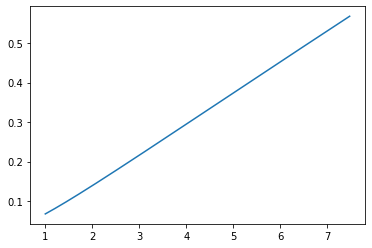

In [22]:
plt.plot(x_vals, y_vals)

In [23]:
plt.show()

In [24]:
vals = [pivot_df['sort_arr'][pivot_df.index[i]] for i in range(0, len(pivot_df.index))]

In [25]:
dpts = [float(x) for x in list(pivot_df.index)]

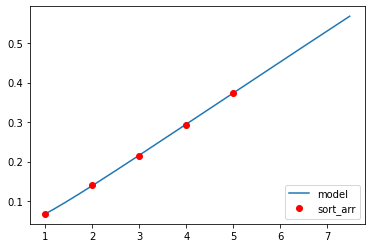

In [26]:
fig = plt.figure()

plt.xticks(range(int(x_vals[0]), int(x_vals[-1]) + 1, 1))
plt.plot(x_vals, y_vals, label='model')
plt.plot(dpts, vals, 'ro', label='sort_arr')

plt.legend(loc='lower right')